Proyecto: Telecom X - Etapa 1
==============================

## Evasión (Churn) de clientes

## Índice

1. Descripción del proyecto.
2. Importación de librerías y extracción de datos.
3. Análisis Exploratorio de Datos (EDA).
   - 3.1 Exploración y Transformación de datos.
   - 3.2 Análisis y visualización de datos.
     - Antigüedad y Facturación.
     - Servicios.
     - Perfil del cliente.
   - 3.3 Bulletpoints: Análisis y visualización de datos
4. Análisis de correlación.

# 1. Descripción del proyecto

Proyecto "Churn de Clientes" para la compañía Telecom X. 

La empresa enfrenta una alta tasa de cancelaciones y necesita comprender los factores que llevan a la pérdida de clientes.

Tu desafío será recopilar, procesar y analizar los datos, utilizando Python y sus principales bibliotecas para extraer información valiosa. A partir de tu análisis, el equipo de Data Science podrá avanzar en modelos predictivos y desarrollar estrategias para reducir la evasión.

## Aclaraciones:

Tarjetas tablero Trello:

* **Columna de cuentas diarias**
* **Estandarización y transformación de datos (opcional)**

### Columna de cuentas diarias

Cree la columna e hice el boxplot, y lo cierto es que era practicamente igual al de Charges.Monthly solo que con una escala distinta ya que corresponde al gasto diario. La verdad no veo mucho valor en esto, a mi parecer resulta en información redundante, y no creo que una persona piense "cuanto me cuesta el servicio de teléfono y/o internet al día", me parece algo que más comunmente se "juzga" de manera mensual.<br>

Por lo que terminé eliminando el gráfico, pero mantuve la columna para que cuando haga el heatmap con la correlación entre variables, pueda identificar cual de estas dos influye más en el Churn.

### Estandarización y transformación de datos (opcional)

Inicialmente no mapee los valores Yes y No a 1 y 0, ya que es mucho más fácil leer palabras en un informe, que identificar que 1 es positivo y 0 es negativo, justamente para stakeholders no técnicos, creo que el hecho de leer Yes y No es más accesible.<br>

En cuanto al nombre de las columnas, opté por dejar sus nombres como están, y marcar siempre que se mencionen en negritas, traducirlas yo mismo, y dejar entre paréntesis el nombre de la columna original, es decir, por ejemplo, cuando hablo de "Churn" mantuve un formato como el siguiente: **Evasión *(Churn)* de clientes**, o **Método de pago *(PaymentMethod)***.

Si bien este es un proyecto provisto por la academia Alura en un programa de estudio, creo que la idea es abordar los proyectos como si estuviesemos en el mundo real, entonces, con el contexto que tengo, pienso lo siguiente: Si la base de datos ya está en inglés, lo más probable es que la empresa maneje clientes/directivos/mercados internacionales, por lo qué remover completamente los términos en inglés no me parece del todo adecuado.

Además debo admitir que en muchas ocasiones el inglés es más breve, evitando que los nombres de columnas se vuelvan excesivamente largos, y también evitando acentos y otros caracteres que pueden traer problemas en el entorno computacional.

Por lo que he decidido no mapear ni traducir las columnas
.
El mapeo de Yes/No a valores 1 y 0 se hará al final al guardar *(load)* los datos preprocesados.

# 2. Importación de librerías y extracción de datos

## Importación de librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from pathlib import Path

from IPython.display import clear_output

## Paths

In [2]:
figures_path = Path('img')
if not figures_path.exists():
    figures_path.mkdir(parents=True)  # 'parents=True' crea directorios intermedios si es necesario
    print("Directorio creado.")
else:
    print("El directorio ya existe.")

El directorio ya existe.


In [3]:
data_path = Path('src')

if not data_path.exists():
    data_path.mkdir(parents=True)  # 'parents=True' crea directorios intermedios si es necesario
    print("Directorio creado.")
else:
    print("El directorio ya existe.")

El directorio ya existe.


## Extracción de datos

In [4]:
# API donde se encuentra los datos
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json'

# Solicitud a la API
r = requests.get(url)

# Imprimir estado de la respuesta
print(r.status_code)
# Verificar tipo de contenido
#print(r.headers['Content-type'])

# Escribir el archivo para normalización
#with open('TelecomX_Data.json', 'wb') as f:
   # f.write(r.content)

200


In [5]:
# Leer el archivo
with open('TelecomX_Data.json', 'r') as f:
    raw_data = json.loads(f.read())

In [6]:
# Normalización del JSON
raw_data = pd.json_normalize(raw_data)

In [7]:
raw_data[raw_data['internet.InternetService'] == 'No']

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
20,0023-UYUPN,No,Female,1,Yes,No,50,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Electronic check,25.20,1306.3
23,0030-FNXPP,No,Female,0,No,No,3,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.85,57.2
24,0031-PVLZI,Yes,Female,0,Yes,Yes,4,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.35,76.35
27,0040-HALCW,No,Male,0,Yes,Yes,54,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),20.40,1090.6
28,0042-JVWOJ,No,Male,0,No,No,26,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),19.60,471.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7250,9970-QBCDA,No,Female,0,No,No,6,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),19.70,129.55
7252,9972-EWRJS,No,Female,0,Yes,Yes,67,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),19.25,1372.9
7256,9975-GPKZU,No,Male,0,Yes,Yes,46,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.75,856.5
7257,9975-SKRNR,No,Male,0,No,No,1,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,18.90,18.9


In [8]:
# Guardar el archivo JSON normalizado
raw_data.to_json('TelecomX_Data_norm.json')

In [9]:
columnas = raw_data.columns
columnas

Index(['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod',
       'account.Charges.Monthly', 'account.Charges.Total'],
      dtype='object')

In [10]:
nuevas_columnas = [
    columnas
    .str.replace('customer.', '')
    .str.replace('phone.', '')   
    .str.replace('internet.', '')
    .str.replace('account.', '').tolist()
]

In [11]:
nuevas_columnas

[['customerID',
  'Churn',
  'gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'tenure',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'Charges.Monthly',
  'Charges.Total']]

In [12]:
# Crear copia para mantener datos en su estado original por si se necesitan
df = raw_data.copy()

# Utilizar la lista con las columnas con nombres normalizados
df.columns = nuevas_columnas[0]

# 3. Análisis Exploratorio de Datos (EDA)

## 3.1 Exploración y Transformación de datos

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


### Observaciones:

El conjunto de datos al parecer no presenta valores nulos *(Missing values)*.<br>
Sin embargo, podemos observar que si bien `'Charges.Monthly'` tiene tipo de dato `float64`, `'Charges.Total'` no ha sido tomada como columna numérica, a pesar de que a simple vista parece contener solo información numérica. Esto puede deberse a que haya valores mal cargados. Por lo que habrá que investigar más en detalle esta columna.

### Variables numéricas

In [14]:
# Intentar convertir la columna a tipo coma flotante para ver que error arroja
#df['Charges.Total'].astype(np.float64)

El error obtenido indica que no se puede convertir `' '` en `float64`.
Por lo que inicialmente reemplazaré dicho string por 0 e intentar ejecutar el código anterior nuevamente para ver si esto soluciona el problema

In [15]:
df[df['Charges.Total'] == ' ']

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
975,1371-DWPAZ,No,Female,0,Yes,Yes,0,No,No phone service,DSL,...,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,
1775,2520-SGTTA,No,Female,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,
1955,2775-SEFEE,No,Male,0,No,Yes,0,Yes,Yes,DSL,...,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,
2075,2923-ARZLG,No,Male,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,
2232,3115-CZMZD,No,Male,0,No,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,
2308,3213-VVOLG,No,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,
2930,4075-WKNIU,No,Female,0,Yes,Yes,0,Yes,Yes,DSL,...,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,
3134,4367-NUYAO,No,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,
3203,4472-LVYGI,No,Female,0,Yes,Yes,0,No,No phone service,DSL,...,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,
4169,5709-LVOEQ,No,Female,0,Yes,Yes,0,Yes,No,DSL,...,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,


In [16]:
df[df['Charges.Total'] == ' '].index == df[df['tenure'] == 0].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

#### Observaciones: Valores faltantes `Charges.Total`

Es posible observar que los valores faltantes en Charge.Total pertenecen a aquellos contratos nuevos que aun no tienen siquiera un mes de antiguedad, por lo que aun no se les ha cobrado por el servicio, lo que lleva a que no tengan nada en dicha columna.
Esto sera solucionado reemplazando el espacio en blanco por 0.

In [17]:
df['Charges.Total'] = df['Charges.Total'].replace(' ', '0')

In [18]:
df['Charges.Total'] = df['Charges.Total'].astype(np.float64)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


In [20]:
df['Charges.Daily'] = round(df['Charges.Monthly'] / 30, 2)

In [21]:
df.columns

Index(['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly', 'Charges.Total',
       'Charges.Daily'],
      dtype='object')

In [22]:
df.columns = ['CustomerID', 'Churn', 'Gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'Tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'ChargesMonthly', 'ChargesTotal',
       'ChargesDaily']

In [23]:
columnas_ordenadas = ['CustomerID', 'Gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'Tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod',
       'ChargesDaily', 'ChargesMonthly', 'ChargesTotal', 'Churn']
df = df[columnas_ordenadas]
df.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesDaily,ChargesMonthly,ChargesTotal,Churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,DSL,No,...,Yes,Yes,No,One year,Yes,Mailed check,2.19,65.6,593.30,No
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,DSL,No,...,No,No,Yes,Month-to-month,No,Mailed check,2.00,59.9,542.40,No
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,2.46,73.9,280.85,Yes
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,3.27,98.0,1237.85,Yes
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,Fiber optic,No,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,2.80,83.9,267.40,Yes


### 3.1.2 Variables categóricas

Lo primero será verificar que la columna `CustomerID` tenga la misma cantidad de valores únicos como filas en el DataFrame

In [24]:
len(df['CustomerID'].unique())

7267

Se puede observar que la columna `CustomerID` cuenta con 7267 valores unicos, que es exactamente la cantidad de registros en el DataFrame, lo que quiere decir que no hay registros duplicados.

In [25]:
columnas_categoricas = ['Churn', 'Gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod']
for columna in columnas_categoricas:
    print(f'Valores unicos en columna {columna}:\n{df[columna].unique()}\n')

Valores unicos en columna Churn:
['No' 'Yes' '']

Valores unicos en columna Gender:
['Female' 'Male']

Valores unicos en columna SeniorCitizen:
[0 1]

Valores unicos en columna Partner:
['Yes' 'No']

Valores unicos en columna Dependents:
['Yes' 'No']

Valores unicos en columna PhoneService:
['Yes' 'No']

Valores unicos en columna MultipleLines:
['No' 'Yes' 'No phone service']

Valores unicos en columna InternetService:
['DSL' 'Fiber optic' 'No']

Valores unicos en columna OnlineSecurity:
['No' 'Yes' 'No internet service']

Valores unicos en columna OnlineBackup:
['Yes' 'No' 'No internet service']

Valores unicos en columna DeviceProtection:
['No' 'Yes' 'No internet service']

Valores unicos en columna TechSupport:
['Yes' 'No' 'No internet service']

Valores unicos en columna StreamingTV:
['Yes' 'No' 'No internet service']

Valores unicos en columna StreamingMovies:
['No' 'Yes' 'No internet service']

Valores unicos en columna Contract:
['One year' 'Month-to-month' 'Two year']

Valores 

#### Observaciones iniciales: Variables categóricas

* La variable `Churn` tambien presenta valores incomplentos, solo que estan disfrazados por `' '`, por eso no fueron captados en el comando `df.info()`
* La variable `SeniorCitizen` tiene valores `0 y 1`. Esto resulta inconsistente con el resto de variables que toman valores `Yes` y `No`. Si bien el formato de esta columna sería el correcto para el equipo de Data Science, temporalmente mantendré el formato del resto de columnas ya que estaré analizando carácteristicas, al final entregaré el conjunto de datos con las variables mapeadeas correctamente para su utilización en modelos predictivos.
* Otra observación es que existe cierta información que puede resultar redundante. Todas los clientes que tengan `InternetService == 'No'`, tendrán las columnas `[OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies] == 'No internet service'`. Para mantener una uniformidad categórica, simplemente cambiaré ese `'No internet service'` por `'No'`. Lo mismo para la columna `MultipleLines` donde el valor es `No phone service`

In [26]:
# Mapeo columna SeniorCitizen
df['SeniorCitizen'] = df['SeniorCitizen'].apply(lambda row: 'Yes' if row == 1 else 'No')

In [27]:
int_service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies']

In [28]:
df['MultipleLines'] = df['MultipleLines'].apply(lambda row: row.replace('No phone service', 'No'))

In [29]:
for columna in int_service_columns:
    df[columna] = df[columna].apply(lambda row: row.replace('No internet service', 'No'))

In [30]:
columnas_categoricas = ['Churn', 'Gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod']
for columna in columnas_categoricas:
    print(f'Valores unicos en columna {columna}:\n{df[columna].unique()}\n')

Valores unicos en columna Churn:
['No' 'Yes' '']

Valores unicos en columna Gender:
['Female' 'Male']

Valores unicos en columna SeniorCitizen:
['No' 'Yes']

Valores unicos en columna Partner:
['Yes' 'No']

Valores unicos en columna Dependents:
['Yes' 'No']

Valores unicos en columna PhoneService:
['Yes' 'No']

Valores unicos en columna MultipleLines:
['No' 'Yes']

Valores unicos en columna InternetService:
['DSL' 'Fiber optic' 'No']

Valores unicos en columna OnlineSecurity:
['No' 'Yes']

Valores unicos en columna OnlineBackup:
['Yes' 'No']

Valores unicos en columna DeviceProtection:
['No' 'Yes']

Valores unicos en columna TechSupport:
['Yes' 'No']

Valores unicos en columna StreamingTV:
['Yes' 'No']

Valores unicos en columna StreamingMovies:
['No' 'Yes']

Valores unicos en columna Contract:
['One year' 'Month-to-month' 'Two year']

Valores unicos en columna PaperlessBilling:
['Yes' 'No']

Valores unicos en columna PaymentMethod:
['Mailed check' 'Electronic check' 'Credit card (auto

In [31]:
df[df['Churn'] == '']

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesDaily,ChargesMonthly,ChargesTotal,Churn
30,0047-ZHDTW,Female,No,No,No,11,Yes,Yes,Fiber optic,Yes,...,No,No,No,Month-to-month,Yes,Bank transfer (automatic),2.63,79.00,929.30,
75,0120-YZLQA,Male,No,No,No,71,Yes,No,No,No,...,No,No,No,Two year,Yes,Credit card (automatic),0.66,19.90,1355.10,
96,0154-QYHJU,Male,No,No,No,29,Yes,No,DSL,Yes,...,Yes,No,No,One year,Yes,Electronic check,1.96,58.75,1696.20,
98,0162-RZGMZ,Female,Yes,No,No,5,Yes,No,DSL,Yes,...,Yes,No,No,Month-to-month,No,Credit card (automatic),2.00,59.90,287.85,
175,0274-VVQOQ,Male,Yes,Yes,No,65,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,One year,Yes,Bank transfer (automatic),3.44,103.15,6792.45,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7158,9840-GSRFX,Female,No,No,No,14,Yes,Yes,DSL,No,...,No,No,No,One year,Yes,Mailed check,1.81,54.25,773.20,
7180,9872-RZQQB,Female,No,Yes,No,49,No,No,DSL,Yes,...,No,Yes,No,Month-to-month,No,Bank transfer (automatic),1.36,40.65,2070.75,
7211,9920-GNDMB,Male,No,No,No,9,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,2.54,76.25,684.85,
7239,9955-RVWSC,Female,No,Yes,Yes,67,Yes,No,No,No,...,No,No,No,Two year,Yes,Bank transfer (automatic),0.64,19.25,1372.90,


In [32]:
print(f'Porcentaje de Valores faltantes en etiqueta objetivo: {round(224 / df.shape[0] * 100,2)}%')

Porcentaje de Valores faltantes en etiqueta objetivo: 3.08%


#### Observaciones:

Ya que lo que se busca analizar es justamente el **Churn** de clientes, completar 224 registros sería perjudicar el análisis, ya que esto es análisis de datos, no predicción, por lo que estoy analizando lo "historico", no puedo inferir si estos tienen `Churn == Yes` o `Churn == No`.<br> 
Se podrían aplicar técnicas de ML no supervisado como KMeans para etiquetar los datos, pero por lo pronto dejaré estos registros almacenados en una variable aparte para no descartarlos por completo.

In [33]:
df_churn = df.copy()
df_unknown = df_churn.query('Churn != "Yes" & Churn != "No"')
df_churn = df_churn.query('Churn == "Yes" | Churn == "No"')
df_unknown['Churn'] = df_unknown['Churn'].apply(lambda row: row.replace('', 'Unknown'))

In [34]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 
 17  

In [35]:
df_churn.describe()

,Tenure,ChargesDaily,ChargesMonthly,ChargesTotal
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,2.158675,64.761692,2279.734304
std,24.559481,1.003088,30.090047,2266.794470
min,0.000000,0.610000,18.250000,0.000000
25%,9.000000,1.180000,35.500000,398.550000
50%,29.000000,2.340000,70.350000,1394.550000
75%,55.000000,2.990000,89.850000,3786.600000
max,72.000000,3.960000,118.750000,8684.800000


## 3.2 Análisis y visualización de datos

Para comprender mejor los **factores que influyen en el abandono de clientes** en la empresa **Telecom X**, se plantean las siguientes preguntas orientadoras del análisis:

**Antigüedad y facturación**

1. ¿Existe relación entre la antigüedad del cliente y el abandono?
2. ¿Existe relación entre el gasto mensual del cliente y su tendencia a dejar la empresa?
3. ¿Existe relación en el gasto total a lo largo del ciclo de vida del cliente en la empresa y la posiblidad de abandono?

**Servicios**

4. ¿Algún servicio (PhoneService o InternetService) presenta mayor influencia en el abandono de clientes?
5. ¿Existe relación entre la cantidad de servicios contratados y el abandono del cliente?
6. ¿Cuál es el tipo de contrato adquirido por el cliente con mayor tendencia a la cancelación del servicio?
7. ¿Algún método de pago influye en el abandono del cliente?

**Perfil del cliente**

8. ¿Algún género tiene mayor tendencia a dejar la empresa?
9. ¿La edad (específicamente ser un ciudadano mayor), influye en la posibilidad de que un cliente abandone?
10. ¿Existe relación entre la situación familiar del cliente *(pareja, personas a cargo)* y la posibilidad de abandono?

### Exploración: Balance del dataset

In [36]:
# Colores de la paleta 'colorblind'
colors = sns.color_palette('colorblind')
cat_colors = ['#176d9c','#c38820','#158b6a']
churn_colors = ['#4682b4', '#e9611d']

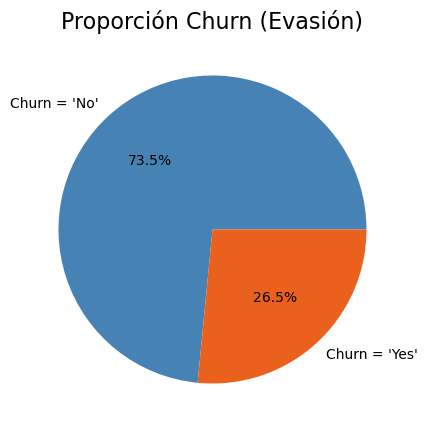

In [37]:
churns = df_churn.groupby('Churn')['Churn'].value_counts()
churns = pd.DataFrame(churns)
fig, ax = plt.subplots(figsize=(6,5))
ax = plt.pie(data=churns,
             x=churns['count'],
             labels=["Churn = 'No'", "Churn = 'Yes'"],
             autopct='%1.1f%%',
             colors=churn_colors)

plt.title('Proporción Churn (Evasión)', fontsize=16)

plt.show()

### **Antigüedad y facturación**

#### 📌 1. ¿Existe relación entre la antigüedad del cliente y el abandono?

Este será el primer análisis ya que la relación entre la antigüedad del cliente y su tendencia a dejar la empresa ofrecerá un panorama general para entender que segmento (antiguos o nuevos) es más propenso a irse.

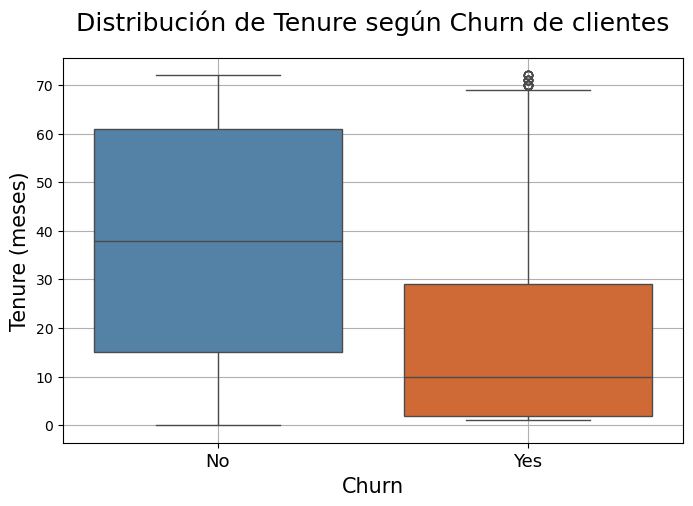

In [38]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.boxplot(data=df_churn, x='Churn', y='Tenure', hue='Churn', palette=churn_colors)
plt.title('Distribución de Tenure según Churn de clientes', fontsize=18, pad=20)
plt.xlabel('Churn', fontsize=15)
plt.ylabel('Tenure (meses)', fontsize=15)
plt.xticks(fontsize=13)
plt.grid(True)

fig.savefig(figures_path/'boxplot_Churn_Tenure.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

#### Observaciones: Distrubución de Tenure (Antigüedad) según Churn (Evasión) de clientes.

`Boxplot Churn == 'Yes'`

*Características*:
* Los lados de la caja van de los valores 2 hasta 29 meses aproximadamente
* Mediana ubicada en el valor 10
* El bigote inferior se encuentra en el valor 1 y el bigote superior en 69 aproximadamente, con unos cuantos valores atípicos *(outliers)* por encima.

*Interpretación:*

* La caja es más compacta a comparación del Boxplot de `Churn == 'No'` lo que indica una distribución más concentrada.
* **Mediana = 10**: el 50% de los clientes que abandonan la empresa lo hacen con 10 meses o menos de antigüedad.
* **El tercer cuartil (Q3)** se ubica en 29 meses, lo que indica que el 75% de los clientes que se dan de baja lo hacen antes de cumplir 30 meses con la empresa.

`Boxplot Churn == 'No'`

*Características*

* La caja se extiende desde los 16 hasta los 61 meses aproximadamente.
* La mediana está en torno a los 38 meses.
* El bigote inferior llega hasta 0 y el bigote superior hasta 72.  

*Interpretación:*

* La distribución es más simétrica y extendida, indicando una mayor variabilidad en los clientes que permanecen en la empresa.
* La mediana de 38 sugiere que la mitad de los clientes más leales tienen más de 3 años de antigüedad.


**Conclusiones:**

* Existe una fuerte tendencia al abandono entre los clientes nuevos. La mayoría de las bajas ocurren antes del primer año.
* Sería interesante analizar las diferencias entre clientes con `Tenure` entre 16 y 30 meses, para entender qué factores podrían estar influyendo en la retención o abandono en ese período intermedio.
* Asimismo, conviene estudiar el perfil de los clientes con menos de 15 meses de antigüedad, para identificar posibles oportunidades de mejora en la experiencia inicial del cliente.

**Debido a que los gráficos Boxplot no son fácil de entener para todo tipo de audiencias, exploraré algunas alternativas para incluir la distribución de variables en reportes**

#### Alternativa 1

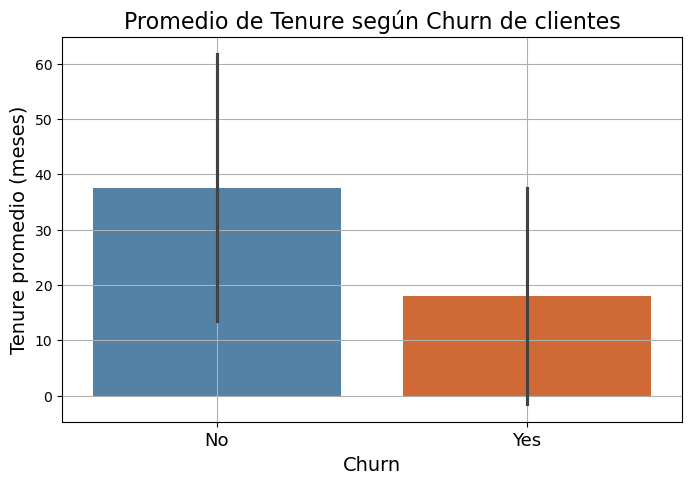

In [39]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df_churn, x='Churn', y='Tenure', hue='Churn', palette=churn_colors, errorbar='sd')
plt.title('Promedio de Tenure según Churn de clientes', fontsize=16)
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Tenure promedio (meses)', fontsize=14)
plt.xticks(fontsize=13)
plt.grid(True)
plt.show()

#### Alternativa 2

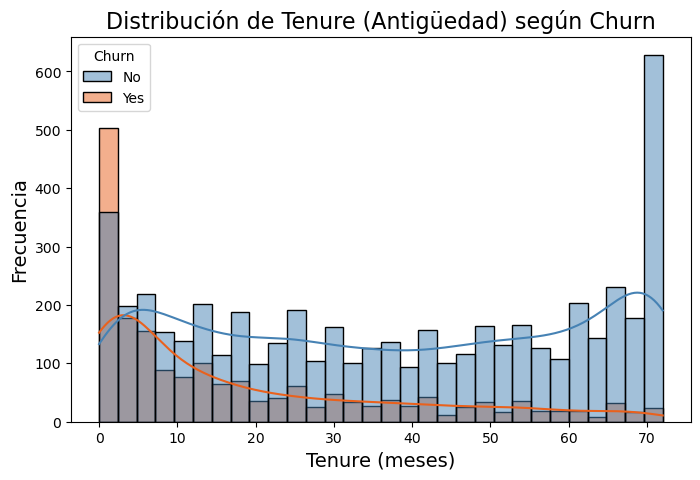

In [40]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df_churn, x='Tenure', hue='Churn', kde=True, palette=churn_colors, bins=30, alpha=0.5)
plt.title('Distribución de Tenure (Antigüedad) según Churn', fontsize=16)
plt.xlabel('Tenure (meses)', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

#### Alternativa 3

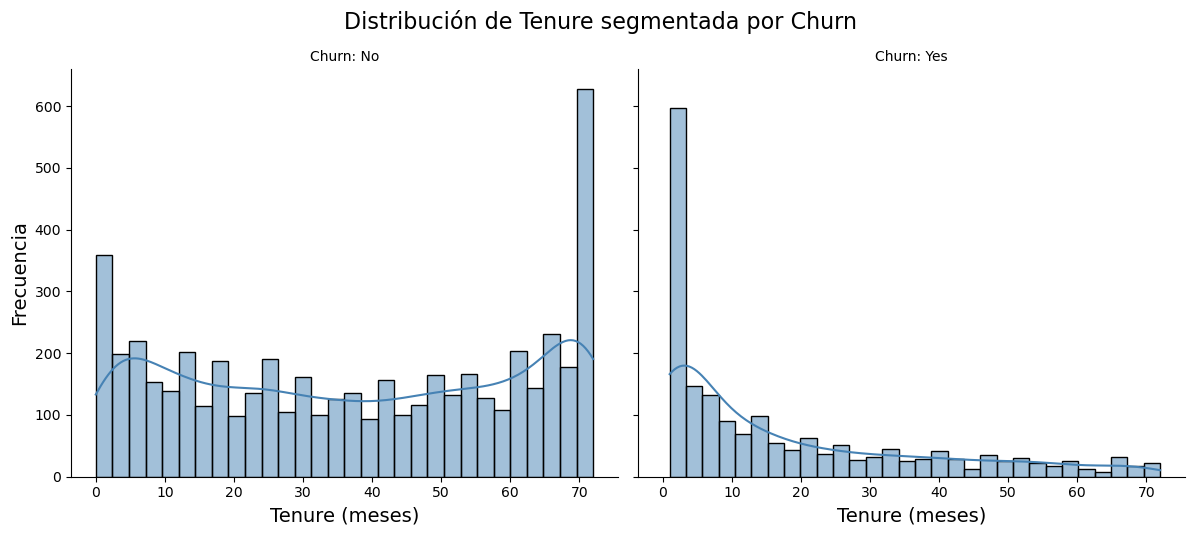

In [41]:
g = sns.FacetGrid(df_churn, col="Churn", height=5, aspect=1.2)
g.map(sns.histplot, "Tenure", bins=30, color='steelblue', kde=True)
g.set_titles("Churn: {col_name}", fontsize=16)
g.set_axis_labels("Tenure (meses)", "Frecuencia", fontsize=14)
g.fig.suptitle("Distribución de Tenure segmentada por Churn", fontsize=16, y=1.05)
plt.show()

In [42]:
def histograma_churn(df, columna, xlabel: str = columna):
    fig, axes = plt.subplots(2,1, figsize=(8,6))

    sns.histplot(data=df[df['Churn'] == 'No'], x=columna, bins=30, color=churn_colors[0], kde=True, ax=axes[0])
    axes[0].set_title("Churn = 'No'", fontsize=15, fontweight='bold', loc='left', color='teal')
    axes[0].set_xlabel(xlabel, fontsize=13)
    axes[0].set_ylabel('Frecuencia', fontsize=13)
    
    sns.histplot(data=df[df['Churn'] == 'Yes'], x=columna, bins=30,  color=churn_colors[1], kde=True, ax=axes[1])
    axes[1].set_title("Churn = 'Yes'", fontsize=15, fontweight='bold', loc='left', color='indianred')
    axes[1].set_xlabel(xlabel, fontsize=13)
    axes[1].set_ylabel('Frecuencia', fontsize=13)
    
    sns.despine()
    plt.suptitle(f'Distribución de {xlabel} según Evasión (Churn)', fontsize=18, y=1.01)
    plt.subplots_adjust(hspace=2)
    plt.tight_layout()
    
    fig.savefig(f'{figures_path}/hist_Churn_{columna}.png',
                    transparent=False,
                    dpi=300,
                    bbox_inches='tight')
    
    plt.show()
    return fig

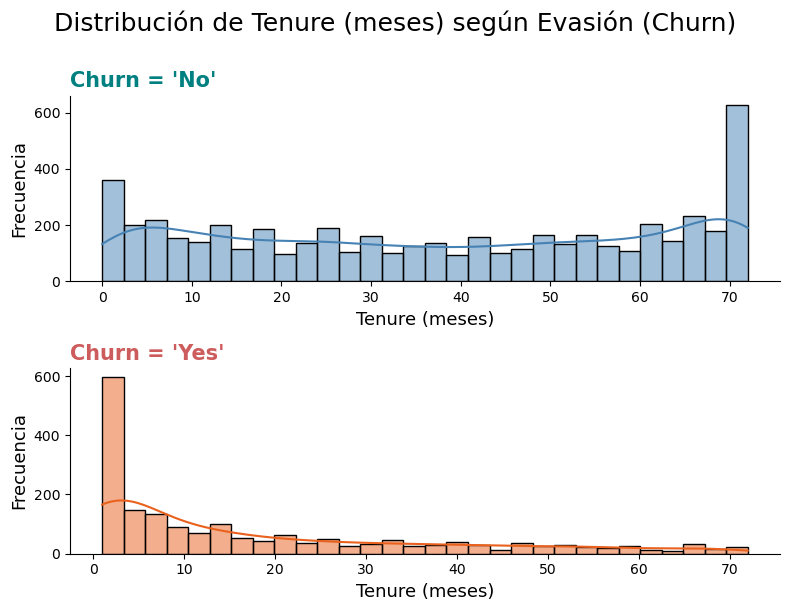

In [43]:
hist_tenure = histograma_churn(df_churn, 'Tenure', 'Tenure (meses)')

#### 📌 2. ¿Existe relación entre el gasto mensual del cliente y su tendencia a dejar la empresa?

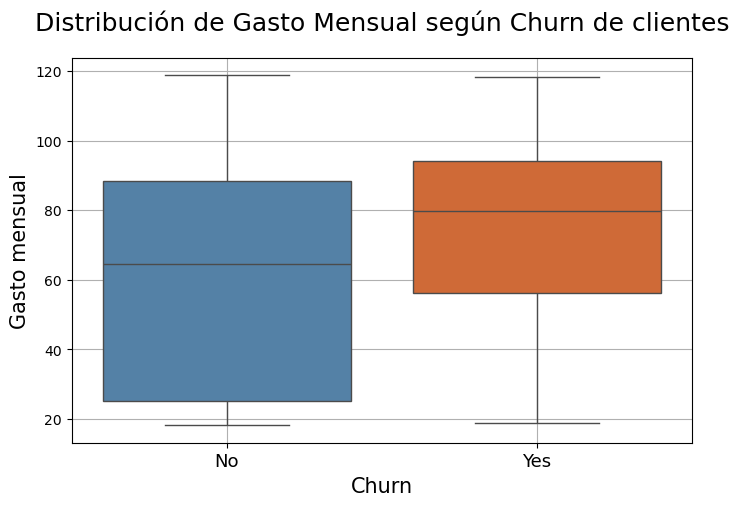

In [44]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.boxplot(data=df_churn, x='Churn', y='ChargesMonthly', hue='Churn', palette=churn_colors)
plt.title('Distribución de Gasto Mensual según Churn de clientes', fontsize=18, pad=20)
plt.xlabel('Churn', fontsize=15)
plt.ylabel('Gasto mensual', fontsize=15)
plt.xticks(fontsize=13)
plt.grid(True)

fig.savefig(figures_path/'boxplot_Churn_ChargesMonthly.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

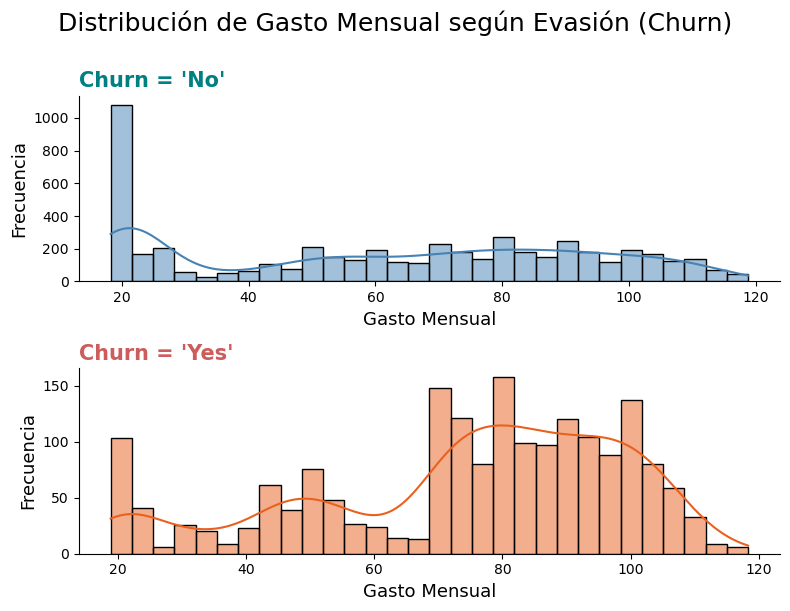

In [45]:
hist_chargesmonthly = histograma_churn(df_churn, 'ChargesMonthly', 'Gasto Mensual')

#### Observaciones: Distribución de ChargesMonthly (gasto mensual) según Churn (abandono) de clientes.

`Boxplot Churn == 'Yes'`

*Características:*

* El 50% *(Q1 a Q3)* de los clientes que abandonan la empresa gastan entre 56 y 95 dólares aproximadamente *(limites de la caja)*.
* Mediana ~79.
* No existen valores atípicos.

*Interpretación:*

* La caja de `Churn == 'Yes'` es más compacta que la de `Churn == 'No'` al igual que en el análisis anterior, esto quiere decir que la distribución de los clientes que abandonan la empresa es más concentrada que los que no lo hacen. Lo que podría indicar que el gasto mensual del cliente es un gran influyente en relación al abandono.
* **Mediana ~79**: 50% del total de clientes que dejan la empresa gasta entre ~19 USD y ~79 USD de manera mensual.
* **Primer cuartil (Q1) y Mediana (Q2)**: La dispersión en este rango es más amplia, siendo entre 56 USD y 79 USD mensuales, lo que implica que la variedad en cuanto a la disconformidad de precio en este rango puede deberse a varias razones.
* **Tercer cuartil (Q3):** Como se vio anteriormente, el 50% de los clientes que abandonan la empresa gastan hasta 79 USD mensuales, y el 75% de los clientes que la empresa pierde gasta entre 79 USD y 90 USD.


`Boxplot Churn == 'No'`

*Características:*

* El gasto mensual de los clientes que deciden mantenerse en la empresa se eleva hasta los ~88 USD mensuales *(Q3)*.
* Mediana ~65.
* No existen valores atípicos.


*Interpretación*

* **Mediana ~65:** El 50% de clientes que deciden quedarse gastan hasta 65 USD mensuales.
* **Rango intercuartílico (IQR):** La dispersion de los clientes que se mantienen en la empresa es más dispersa en comparación a aquellos que deciden abandonar, en un rango de aproximadamente 53 USD mensuales (88 USD - 25 USD). Esto los clientes que deciden quedarse están conformes con el precio que pagan por los serivicios adquiridos mensualmente.

**Conclusiones:**

* La variedad en cuanto a la disconformidad de los precios entre 56 y 79 USD mensuales, puede derivar en el análisis de tipo y cantidad de servicios de cada cliente y el precio que paga mensualmente, para entender por qué deciden dejar la empresa.
* La concentración de registros con un gasto entre 79 y 96 USD mensuales resulta crítica ya que una diferencia de 11 USD mensaules abarca una cuarta parte de los clientes que abandonan la empresa, por lo que la empresa podría ajustar su precificación o generar promociónes que ayuden a la permanencia del cliente hasta los 18 meses aproximadamente, ya que en el análisis anterior fue posible observar que los clientes con más de 16 meses de permanencia en la empresa tienden a quedarse.
* Es posible observar que la mediana de los clientes que deciden abandonar la empresa *(Churn = 'Yes')* segun el gasto mensual en el que incurren, coincide con aproximadamente el 68% de los clientes que deciden quedarse. Lo que sugiere que aquellos clientes con un gasto mensual mayor a 79USD son clientes con riesgo potencial a abandonar la empresa.


#### 📌 3. ¿Existe relación en el gasto total a lo largo del ciclo de vida del cliente en la empresa y la posiblidad de abandono?

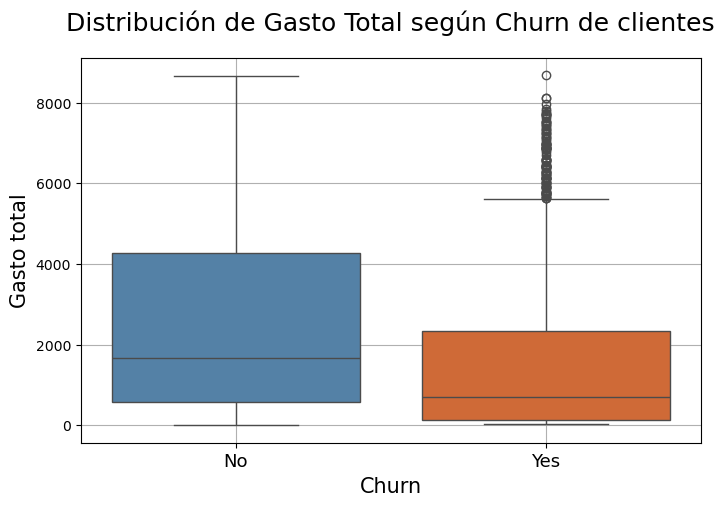

In [46]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.boxplot(data=df_churn, x='Churn', y='ChargesTotal', hue='Churn', palette=churn_colors)
plt.title('Distribución de Gasto Total según Churn de clientes', fontsize=18, pad=20)
plt.xlabel('Churn', fontsize=15)
plt.ylabel('Gasto total', fontsize=15)
plt.xticks(fontsize=13)
plt.grid(True)

fig.savefig(figures_path/'boxplot_Churn_ChargesTotal.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')

plt.show()

In [ ]:
hist_chargestotal = histograma_churn(df_churn, 'ChargesTotal', 'Gasto Total')

#### Observaciones: Distribución de ChargesTotal (gasto total) según Churn (abandono) de clientes.

`Boxplot Churn == Yes`

*Características:*

* Los limites de la caja van desde ~50 hasta ~2200
* Mediana ~800
* Existen varios registros con valores atípicos

*Interpretación:*

* Existe una gran concentración de clientes que abandonan con un gasto total entre ~50 y ~800. Teniendo en cuenta que el promedio de gasto mensual es de 64 USD, esto concuerda con la observación de que gran parte de los clientes que deciden abandonar la empresa lo hacen antes de los 12 meses de antiguedad.
* **Valores Atípicos**: Existe una notable cantidad de clientes con un gasto total elevado que han decidido dejar la empresa. Lo lógico es que sean clientes con una antigüedad considerable, ya que el gasto total supera los 5500 USD. Estos clientes no resaltaron en los dos análisis previos, lo que indica que si bien la tendencia de los clientes es abandonar en las etapas tempranas de la relación con la empresa, existe un grupo de clientes que han decidido abandonar después de una relación ya consolidada, por lo que sería interesante evaluar este grupo por separado para entender que factores influyeron en el abandono y diseñar estrategias de retención.

`Boxplot Churn == No`

*Características:*

* Los limites de la caja van desde ~700 hasta ~4200
* Mediana ~1800
* No existen registros con valores atípicos

*Interpretación:*

* El 50% de clientes que decide quedarse en la empresa tiene un Gasto Total entre 700 y 4200 USD, lo que coincide con una relación ya estable con la organización.

**Conclusiones:**

* Este análisis verifica lo observado en relación al abandono en las etapas tempranas de la relación del cliente con la empresa.
* Además, ha sido posible identificar que existe un grupo de clientes que decidieron abandonar la empresa con una antigüedad considerable, y que el gasto total de estos es bastante elevado, por lo que es necesario evaluar este grupo por separado y entender qué hizo que decidieran terminar su relación con la organización.

In [ ]:
churn_yes = df_churn.query('Churn == "Yes"')
total_q1 = churn_yes['ChargesTotal'].quantile(0.25)
total_q3 = churn_yes['ChargesTotal'].quantile(0.75)
total_iqr = total_q3 - total_q1
upper_bound = total_iqr + total_iqr * 1.5
print(f'Límite superior de Boxplot Churn = "Yes" en relación al Gasto total: {upper_bound}')
outliers_churn_yes = churn_yes[churn_yes['ChargesTotal'] > upper_bound]
print(f'Cantidad de valores atípicos de Churn = "Yes" en relación al Gasto Total: {len(outliers_churn_yes)} clientes')

### **Conclusiones: Antigüedad y Facturación**

De las tres preguntas correspondientes a esta sección, se concluye lo siguiente:

* **Antigüedad y gasto total** muestran un fuerte vínculo con el abandono, por lo que `Tenure` y `Charges.Total` se perfilan como variables potencialmente relevantes para el modelo predictivo de `Churn`.
* Se identificó un grupo de **clientes de alto valor que abandonan**, lo cual no concuerda con el patrón general (abandono temprano). Este segmento debería ser investigado en profundidad —por ejemplo, a través de entrevistas post-baja o análisis multivariable— para detectar patrones comunes o eventos desencadenantes, con el objetivo de generar alertas tempranas.
* Se observa una **alta concentración de abandono** cuando el gasto mensual supera los **79 USD**, dentro de un margen de **11 USD**. Esto sugiere que podría haber sensibilidad al precio en la gama **media-alta**, posiblemente por la competencia. Reforzando así la necesidad de analizar la relación entre `MonthlyCharges`, **tipo de servicios contratados y churn**, para ajustar estrategias de precio y retención.

### **Servicios**

#### 📌 4. ¿Algún servicio (PhoneService o InternetService) presenta mayor influencia en el abandono de clientes?

In [ ]:
df_servicios = df_churn.copy()

In [ ]:
df_servicios.head(0)

In [ ]:
df_servicios.drop(['CustomerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure'], axis=1, inplace=True)
df_servicios.head()

##### **Phone Service**

In [ ]:
df_phone = df_servicios.groupby('Churn')['PhoneService'].value_counts().to_frame()
df_phone.reset_index(inplace=True)

In [ ]:
df_phone

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.barplot(data=df_phone, x='Churn', y='count', hue='PhoneService', palette='colorblind')

ax.set_title('Relación entre Phone Service y Churn', fontsize=18)
ax.set_xlabel('Churn', fontsize=15)
ax.set_ylabel('Cantidad de Clientes', fontsize=15)
ax.legend(title='PhoneService')
ax.set_xticks(ticks=df_phone['Churn'], labels=df_phone['Churn'], ha='center', size=12)

for bar in ax.patches:
    altura = bar.get_height()
    if altura == 0:
        continue
    else:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            altura + 30,
            f'{altura:.0f}',
            ha='center')


sns.despine()
plt.tight_layout()

fig.savefig(figures_path/'bar_Churn_PhoneService.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')

plt.show()

In [ ]:
df_phone

In [ ]:
df_phone = df_phone.pivot(index='PhoneService', columns='Churn', values='count')
df_phone.columns = ['No Churn', 'Churn']
df_phone.reset_index(inplace=True)

In [ ]:
valores_no_churn = df_phone['No Churn']
valores_churn = df_phone['Churn']
labels = ['No tiene Phone Service', 'Tiene Phone Service']

# Crear figura
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

explode = (0.05, 0.05)

# Pie para clientes que NO abandonaron
axes[0].pie(valores_no_churn,
            labels=labels,
            autopct='%1.1f%%',
            startangle=90,
            explode=explode,
            colors=sns.color_palette(['powderblue', churn_colors[0]])
           )
axes[0].set_title("Churn = 'No'", fontsize=15, fontweight='bold', color='teal')

# Pie para clientes que SÍ abandonaron
axes[1].pie(valores_churn,
            labels=labels,
            autopct='%1.1f%%',
            startangle=90,
            explode=explode,
            colors=sns.color_palette(['#ffe1d3', churn_colors[1]])
           )
axes[1].set_title("Churn = 'Yes'", fontsize=15, fontweight='bold', color='chocolate')

# Título general
plt.suptitle('Phone Service\nComparativa según Evasión (Churn)', fontsize=18)

plt.tight_layout()
plt.subplots_adjust(hspace=0.8)

fig.savefig(figures_path/'pie_Churn_PhoneService.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')

plt.show()

##### **Observaciones: Phone service**

* La proporción de clientes que cuentan con servicio telefónico que deciden quedarse o abandonar la empresa **varía solo en un 0.8%**, lo que indica que esta variable no tiene poder explicativo por sí sola.

##### **Internet Service**

In [ ]:
df_internet = df_servicios.groupby('Churn')['InternetService'].value_counts().to_frame()
df_internet

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.barplot(data=df_internet, x='Churn', y='count', hue='InternetService', palette='colorblind')

ax.set_title('Relación entre Internet Service y Churn', fontsize=18, pad=20)
ax.set_xlabel('Churn', fontsize=15)
ax.set_ylabel('Cantidad de Clientes', fontsize=15)
ax.legend(title='InternetService')
ax.tick_params(axis='both', labelsize=12)

for bar in ax.patches:
    altura = bar.get_height()
    if altura == 0:
        continue
    else:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            altura + 30,
            f'{altura:.0f}',
            ha='center')
    
sns.despine()
plt.tight_layout()

fig.savefig(figures_path/'bar_Churn_InternetService.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

##### **Tasa de abandono por Tipo de `InternetService`**

In [ ]:
#df_internet.reset_index(inplace=True)

In [ ]:
dsl = df_internet.query('InternetService == "DSL"')
fiber_optic = df_internet.query('InternetService == "Fiber optic"')
no_internet = df_internet.query('InternetService == "No"')

In [ ]:
dsl_ratio = (dsl.loc['Yes', 'count'] / dsl['count'].sum() * 100).item()
fiber_optic_ratio = (fiber_optic.loc['Yes', 'count'] / fiber_optic['count'].sum() * 100).item()
no_internet_ratio = (no_internet.loc['Yes', 'count'] / no_internet['count'].sum() * 100).item()

In [ ]:
churn_ratio_internetservice = pd.DataFrame({'Tasa abandono (%)': [round(dsl_ratio, 2),
                                                                  round(fiber_optic_ratio, 2), 
                                                                  round(no_internet_ratio, 2)]},
                                           index=['DSL', 'Fiber optic', 'No internet'])
churn_ratio_internetservice.sort_values('Tasa abandono (%)', ascending=False)

In [ ]:
# Crear tabla para exportar como imagen
fig, ax = plt.subplots(figsize=(6, 2))
# Eliminar los ejes
ax.axis('off')

# Tabla
tabla = ax.table(cellText=churn_ratio_internetservice.values,
                 colLabels=churn_ratio_internetservice.columns,
                 rowLabels=churn_ratio_internetservice.index,
                 cellLoc='center',
                 loc='center',
                 colColours=['silver'],
                 cellColours=[['silver'], ['tomato'], ['silver']],
                 rowColours=['silver', 'tomato', 'silver'])

plt.title('Evasión (Churn) - Internet Service', fontsize=14)
# Escalar la tabla para mayor legibilidad
tabla.scale(1, 2)

plt.tight_layout()

fig.savefig(figures_path/'rate_Churn_InternetService.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')

plt.show()

#### Observaciones: Evasión (Churn) en relación al tipo de servicio

**Servicio Telefónico *(PhoneService)***

El servicio telefónico no parece tener una influencia significativa en la evasión *(Churn)* de clientes. Las proporciones de clientes que se quedan y los que se van son muy similares:

* **Clientes que abandonan:**
  - *Con Servicio Telefónico:* **90.9%**
  - *Sin Servicio Telefónico:* **9.1%**
* **Clientes que permanecen:**
  - *Con Servicio Telefónico:* **90.1%**
  - *Sin Servicio Telefónico:* **9.9%**

Esto sugiere que el Phone Service no es un factor decisivo en la retención o pérdida de clientes.

**Servicio de Internet *(InternetService)***

Aquí se observa un contraste significativo entre los distintos tipos de servicio:

* **Fibra Óptica:**
  - *Tasa de abandono:* **41.89%**
  - *Tasa de retención:* **58.11%**
* **Servicio DSL:**
  - *Tasa de abandono:* **18.96**
  - *Tasa de retención:* **81.04%**
* **Sin Servicio de Internet:**
  - *Tasa de abandono:* **7.4%**
  - *Tasa de retención:* **92.6%**

Los clientes con servicio de fibra óptica presentan la tasa de abandono más alta, mientras que aquellos sin servicio de internet son los más propensos a permanecer.

**Conclusión:**

El marcado contraste entre la tasa de abandono de los clientes con **Fibra Óptica** y aquellos **sin servicio de internet** es un **fuerte indicador de insatisfacción** con el servicio de internet, especialmente el de fibra óptica.<br><br>
Será crucial investigar si esto se debe a:
* Problemas de calidad o estabilidad del servicio,
* Relación precio-calidad percibida como desfavorable,
* O factores como atención al cliente, instalación, soporte técnico, etc.

#### 📌 5. ¿Existe relación entre la cantidad de servicios contratados y el abandono del cliente?

In [ ]:
df_servicios.columns

In [ ]:
columnas_map = ['Churn', 'PhoneService', 'MultipleLines',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies']

for columna in columnas_map:
    df_servicios[columna] = df_servicios[columna].map({'Yes': 1, 'No': 0})

In [ ]:
df_servicios['InternetService'] = df_servicios['InternetService'].map({'DSL': 1, 'Fiber optic': 1, 'No': 0})

In [ ]:
columnas_sumar = ['PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies']

In [ ]:
df_servicios['ServiceQuantity'] = df_servicios[columnas_sumar].sum(axis=1)
df_servicios.head()

In [ ]:
df_cantidad_servicios = df_servicios.groupby('ServiceQuantity')['Churn'].value_counts().to_frame()
df_cantidad_servicios.reset_index(inplace=True)
df_cantidad_servicios

In [ ]:
cantidad_servicios = []
tasa_abandono = []

for i in range(1, df_cantidad_servicios['ServiceQuantity'].max()+1):
    q = df_cantidad_servicios[df_cantidad_servicios['ServiceQuantity'] == i]
    churn = q.loc[q['Churn'] == 1, 'count'].item()
    total = q['count'].sum()
    tasa_abandono.append(round(churn / total * 100, 2))
    cantidad_servicios.append(i)

tasa_abandono

In [ ]:
servicios_abandono = pd.DataFrame({'Cantidad Servicios': cantidad_servicios, 'Tasa Abandono (%)': tasa_abandono})

In [ ]:
servicios_abandono

In [ ]:
servicios_abandono

In [ ]:
servicios_abandono.columns = ['Cantidad de Servicios', 'Tasa Abandono (%)']

In [ ]:
data = servicios_abandono[['Cantidad de Servicios', 'Tasa Abandono (%)']].values.tolist()
for dato in data:
    dato[0] = int(dato[0])

# Crear tabla para exportar como imagen
fig, ax = plt.subplots(figsize=(6, 5))
# Eliminar los ejes
ax.axis('off')

color_order=['#c0c0c0', '#ff8c78', '#ff5032','#ef4224','#ff8c78', '#fdbeb2', '#fdbeb2', '#c0c0c0', '#d0d0d0']
cell_colors = [[color, color] for color in color_order]
# Tabla
tabla = ax.table(cellText=data,
                 colLabels=['Cantidad de Servicios', 'Tasa de Abandono (%)'],
                 cellLoc='center',
                 loc='center',
                 colColours=['silver', 'silver'],
                 cellColours=cell_colors)

plt.title('Evasión (Churn) - Cantidad de Servicios Contratados', fontsize=18
         )
# Escalar la tabla para mayor legibilidad
tabla.scale(1, 2)
plt.tight_layout()

fig.savefig(figures_path/'rate_Churn_ServiceQuantity.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')


plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

ax = sns.lineplot(data=servicios_abandono, x='Cantidad de Servicios', y='Tasa Abandono (%)', marker='o')
ax.set_title('Tasa de Abandono según Cantidad de Servicios contratados', fontsize=18, pad=20)
ax.set_xlabel('Cantidad de Servicios', fontsize=15)
ax.set_ylabel('Tasa de Abandono (%)', fontsize=15)
ax.tick_params(axis='both', labelsize=12)

sns.despine()

plt.grid(True, alpha=0.35)
plt.tight_layout()

fig.savefig(figures_path/'linea_tasa_abandono_qservicios.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

In [ ]:
un_servicio = df_servicios[df_servicios['ServiceQuantity'] == 1]
solo_telefono = un_servicio[un_servicio['PhoneService'] == 1].shape[0]
un_servicio = un_servicio.shape[0]
print(f'Cantidad de clientes con un único servicio: {un_servicio}, de los cuales {solo_telefono} cuentan solo con Servicio Telefónico')

In [ ]:
print(f'El {round(solo_telefono / un_servicio * 100, 2)} % de clientes con un solo servicio corresponde a Servicio Telefónico')

#### Observaciones: Tasa de abandono según Cantidad de servicios contratados

El análisis indica que los clientes que contratan pocos servicios son más propensos a abandonar la empresa. La **tasa de evasión** alcanza su **punto más alto** en clientes con **3 servicios contratados (~45%)** y disminuye consistentemente a medida que aumenta la cantidad de servicios.
Esto sugiere que los clientes que se benefician de una mayor integración de servicios presentan una mayor fidelidad.

Por otra parte, la tasa de abandono es relativamente baja en aquellos clientes que cuentan con **solo un servicio** ya que el **93.67%** de estos cuentan solo con **Servicio Telefónico**, lo que concuerda con el análisis anterior donde se determinó que esta característica no presenta una relación significativa con la evasión del cliente.

#### 📌 6. ¿Cuál es el tipo de contrato adquirido por el cliente con mayor tendencia a la cancelación del servicio?

In [ ]:
df_servicios.head()

In [ ]:
contratos = df_servicios.groupby('Contract')['Churn'].value_counts().to_frame()
contratos.reset_index(inplace=True)
contratos

In [ ]:
def pivot_y_tasa_abandono(df, index_col: str):
    df = df.pivot(index=index_col, columns='Churn', values='count')
    df.columns = ['No Churn', 'Churn']
    df = df.reset_index()
    df['Tasa Abandono (%)'] = round(df['Churn'] / (df['Churn'] + df['No Churn']) * 100, 2)
    df = df.sort_values(by='Tasa Abandono (%)', ascending=False)
    return df

In [ ]:
# Pivotear los datos 
df_contratos = pivot_y_tasa_abandono(contratos, 'Contract')
df_contratos

In [ ]:
data = df_contratos[['Contract', 'Tasa Abandono (%)']].values.tolist()


# Crear tabla para exportar como imagen
fig, ax = plt.subplots(figsize=(6, 4))
# Eliminar los ejes
ax.axis('off')

color_order=['tomato', 'silver', 'silver']
cell_colors = [[color, color] for color in color_order]
# Tabla
tabla = ax.table(cellText=data,
                 colLabels=['Contract', 'Tasa de Abandono (%)'],
                 cellLoc='center',
                 loc='center',
                 colColours=['silver', 'silver'],
                 cellColours=cell_colors)

plt.title('Evasión (Churn) - Tipo de Contrato (Contract)', fontsize=18)
# Escalar la tabla para mayor legibilidad
tabla.scale(1, 2)
plt.tight_layout()

fig.savefig(figures_path/'rate_Churn_Contract.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')


plt.show()

In [ ]:
# Crear el gráfico de barras apiladas horizontales
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_frame_on(False)


# Barras horizontales
ax.barh(df_contratos['Contract'], df_contratos['No Churn'], label='No Churn', color=churn_colors[0])
ax.barh(df_contratos['Contract'], df_contratos['Churn'], left=df_contratos['No Churn'], label='Churn', color=churn_colors[1])

# Agregar etiquetas en el centro de cada barra
for i, row in df_contratos.iterrows():
    # Texto para "No Churn"
    ax.text(row['No Churn'] / 2, i, str(row['No Churn']), va='center', ha='center', color='black', fontsize=9)
    
    # Texto para "Churn"
    ax.text(row['No Churn'] + row['Churn'] / 2, i, str(row['Churn']), va='center', ha='center', color='black', fontsize=9)

# Etiquetas y título
ax.set_title('Evasión (Churn) de clientes según Tipo de Contrato', fontsize=18, loc='left', pad=20)
ax.xaxis.set_visible(False)
ax.tick_params(size=0, labelsize=12)

ax.legend()
plt.tight_layout()

fig.savefig(figures_path/'barhstk_Churn_Contract.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')

plt.show()

#### Observaciones: Tasa de Abandono según Tipo de Contrato

Este análisis reafirma que la **fidelización del cliente** está estrechamente vinculada con el tipo de contrato que mantiene con la compañía. Las tasas de abandono observadas son:

* Mes a mes *(Month-to-Month)*: **42.71%**
* Un año *(One year)*: **11.27%**
* Dos años *(Two year)*: **2.83%**

Se evidencia que los clientes con contrato **mes a mes** presentan una mayor propensión a cancelar el servicio. A medida que el **compromiso contractual es más duradero**, la **probabilidad de abandono disminuye** considerablemente.

#### 📌 7. ¿Algún método de pago influye en el abandono del cliente?

In [ ]:
tipo_pago = df_servicios.groupby('PaymentMethod')['Churn'].value_counts().to_frame()
tipo_pago.reset_index(inplace=True)
tipo_pago

In [ ]:
df_tipo_pago = pivot_y_tasa_abandono(tipo_pago, 'PaymentMethod')
df_tipo_pago

In [ ]:
data = df_tipo_pago[['PaymentMethod', 'Tasa Abandono (%)']].values.tolist()


# Crear tabla para exportar como imagen
fig, ax = plt.subplots(figsize=(6, 3))
# Eliminar los ejes
ax.axis('off')

color_order=['tomato', 'silver', 'silver', 'silver']
cell_colors = [[color, color] for color in color_order]
# Tabla
tabla = ax.table(cellText=data,
                 colLabels=['Payment Method', 'Tasa de Abandono (%)'],
                 cellLoc='center',
                 loc='center',
                 colColours=['silver', 'silver'],
                 cellColours=cell_colors)

plt.title('Evasión (Churn) - PaymentMethod (Medio de pago)', fontsize=18)
# Escalar la tabla para mayor legibilidad
tabla.scale(1, 2)

fig.savefig(figures_path/'rate_Churn_PaymentMethod.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')

plt.tight_layout()
plt.show()

In [ ]:
# Crear el gráfico de barras apiladas horizontales
fig, ax = plt.subplots(figsize=(8, 3))

ax.set_frame_on(False)

# Barras horizontales
ax.barh(df_tipo_pago['PaymentMethod'], df_tipo_pago['No Churn'], label='No Churn', color=churn_colors[0])
ax.barh(df_tipo_pago['PaymentMethod'], df_tipo_pago['Churn'], left=df_tipo_pago['No Churn'], label='Churn', color=churn_colors[1])

for idx, row in df_tipo_pago.iterrows():
    tipo = row['PaymentMethod']
    
    # Etiqueta "No Churn"
    nochurn = row['No Churn'] / 2
    ax.text(nochurn, tipo, str(row['No Churn']), va='center', ha='center', color='black', fontsize=9)
    
    # Etiqueta "Churn"
    churn = row['No Churn'] + row['Churn'] / 2
    ax.text(churn, tipo, str(row['Churn']), va='center', ha='center', color='black', fontsize=9)

# Etiquetas y título
ax.set_title('Evasión (Churn) de clientes según Método de Pago', fontsize=16, loc='left', pad=20)
ax.xaxis.set_visible(False)
ax.tick_params(size=0, labelsize=10)
ax.legend()
sns.despine()

plt.tight_layout()

fig.savefig(figures_path/'barhstk_Churn_PaymentMethod.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')

plt.show()

#### Observaciones: Tasa de Abandono según Método de Pago

De este análisis se destacan los siguientes puntos:

* Los métodos de pago automático, **Transferencia Bancaria *(Bank transfer)*** y **Tarjeta de Crédito *(Credit Card)***, presentan la **tasa de abandono más baja**. Esto puede deberse a mayor comodidad, seguridad en cuanto a las fechas de pago evitando así la suspensión del servicio, u otros factores que no se encuentran presentes en el conjunto de datos para su análisis.
* **Factura por correo *(Mailed check)*** tiene una tasa de abandono relativamente baja, aunque mayor a los métodos de pago automáticos.  Una posible explicación es que este método, al ser más tradicional, puede ser preferido por clientes que están habituados a él y mantienen una relación más estable con la empresa.
* **Factura electrónica *(Electronic check)*** muestra **la tasa de abandono más alta**. Una hipótesis plausible es que el envío de facturas por correo electrónico puede derivar en **pérdida** o **desatención del mensaje**, lo cual provocaría demoras en el pago y potencial suspensión del servicio. Sería interesante evaluar si los clientes que abandonan el servicio bajo este método de pago pertenecen al grupo de **Adultos Mayores *(SeniorCitizen)***. Si fuera el caso, podría indicar una brecha digital o dificultades de uso, abriendo oportunidades para implementar estrategias de **acompañamiento** y **soporte personalizado** que mejoren la experiencia de este segmento.

### **Conclusiones: Servicios**

Del análisis realizado sobre la relación entre los servicios contratados y la evasión de clientes, se destacan los siguientes hallazgos clave:

* Los clientes que poseen **solo el servicio telefónico *(PhoneService)*** muestran una **baja tasa de abandono**, lo que sugiere una **satisfacción generalizada con este servicio**.
* En contraste, los clientes que cuentan con **servicio de Fibra Óptica *(Fiber Optic)*** presentan una **tasa de evasión significativamente más alta**, lo cual podría ser indicio de **problemas de calidad o expectativas no cumplidas**.
* Los contratos de tipo **"mes a mes" *(Month-to-Month)*** y los clientes que contratan **pocos servicios** son los **más propensos a abandonar la empresa**.
* Se observa una **insatisfacción notable entre los clientes que utilizan el servicio de Factura Electrónica (Electronic Check)**.


**Sugerencias Estratégicas:**

* Investigar a fondo las **causas del abandono del servicio de Fibra Óptica**. Esto podría incluir:
  - Análisis de reseñas y comentarios negativos.
  - Evaluación de métricas de calidad del servicio (como velocidad o estabilidad de conexión).
  - Comparación con otras tecnologías ofrecidas por la empresa.
* **Diseñar campañas de marketing personalizadas** que incentiven la **contratación de servicios adicionales** bajo **compromisos contractuales más extensos** (por ejemplo, planes anuales). Esto puede:
  - **Reducir la tasa de evasión** al aumentar el compromiso.
  - Aumentar la **percepción de valor** al integrar múltiples servicios.
* **Mejorar la experiencia con la Factura Electrónica**, detectando barreras o puntos de fricción, especialmente entre adultos mayores o clientes con menor familiaridad digital:
  - Promover **métodos de pago automáticos** como alternativa segura y cómoda, reduciendo los abandonos relacionados con olvidos o suspensiones por falta de pago.que mejoren la experiencia de este segmento.

### **Perfil del cliente**

#### 📌 8. ¿Algún género tiene mayor tendencia a dejar la empresa?

In [ ]:
df_perfil = df_churn.copy()

In [ ]:
df_perfil.head(0)

In [ ]:
df_perfil.groupby('Gender')['Gender'].value_counts()

La diferencia entre la cantidad de clientes de cada género no es significativa para este análisis. Se proseguirá a evaluar el Churn con respecto al genero

In [ ]:
df_generos = df_perfil.groupby('Gender')['Churn'].value_counts().to_frame()
df_generos.reset_index(inplace=True)

In [ ]:
df_generos

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

ax = sns.barplot(data=df_generos, x='Gender', y='count', hue='Churn', palette='colorblind')
ax.set_title('Evasión (Churn) según Género', fontsize=18, pad=20)
ax.set_xlabel('Género', fontsize=15)
ax.set_ylabel('Cantidad de clientes', fontsize=15)

for bar in ax.patches:
    height = bar.get_height()
    if height == 0:
        continue
    else:
        ax.text(bar.get_x() + bar.get_width() / 2, 
                height + 30,
                f'{height:.0f}',
                ha='center')
        
sns.despine()
plt.tight_layout()

fig.savefig(figures_path/'bar_Churn_Gender.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')

plt.show()

#### Observaciones: Evasión (Churn) en relación al Género

La distribución de evasión es **prácticamente simétrica entre géneros**, lo cual indica que la variable **Género no aporta poder explicativo** relevante para la predicción o análisis del abandono. Por lo tanto, **no es un factor determinante en la toma de decisiones** relacionada con estrategias de retención.

#### 📌 9. ¿La edad (específicamente ser un ciudadano mayor), influye en la posibilidad de que un cliente abandone?

In [ ]:
df_perfil.groupby('SeniorCitizen')['Churn'].value_counts()

In [ ]:
df_senior = df_perfil.groupby('SeniorCitizen')['Churn'].value_counts().to_frame()
df_senior.reset_index(inplace=True)
df_senior

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

ax = sns.barplot(data=df_senior, x='SeniorCitizen', y='count', hue='Churn', palette='colorblind')
ax.set_title('Evasión (Churn) según Adulto Mayor (Senior Citizen)', fontsize=18, pad=20)
ax.set_xlabel('Adulto Mayor', fontsize=15)
ax.set_ylabel('Cantidad de clientes', fontsize=15)

for bar in ax.patches:
    height = bar.get_height()
    if height == 0:
        continue
    else:
        ax.text(bar.get_x() + bar.get_width() / 2, 
                height + 30,
                f'{height:.0f}',
                ha='center')
        
sns.despine()
plt.tight_layout()

fig.savefig(figures_path/'bar_Churn_SeniorCitizen.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')

plt.show()

In [ ]:
# Pivotear los datos
df_senior = pivot_y_tasa_abandono(df_senior, 'SeniorCitizen')
df_senior

In [ ]:
tabla_senior = df_senior[['SeniorCitizen', 'Tasa Abandono (%)']]
tabla_senior.columns = ['Adulto Mayor', 'Tasa Abandono (%)']
tabla_senior

In [ ]:
data = tabla_senior[['Adulto Mayor', 'Tasa Abandono (%)']].values.tolist()


# Crear tabla para exportar como imagen
fig, ax = plt.subplots(figsize=(5, 2))
# Eliminar los ejes
ax.axis('off')

color_order=['tomato', 'silver']
cell_colors = [[color, color] for color in color_order]
# Tabla
tabla = ax.table(cellText=data,
                 colLabels=['Senior Citizen', 'Tasa de Abandono (%)'],
                 cellLoc='center',
                 loc='center',
                 colColours=['silver', 'silver'],
                 cellColours=cell_colors)

plt.title('Evasión (Churn) - Adulto Mayor (Senior Citizen)', fontsize=18)
# Escalar la tabla para mayor legibilidad
tabla.scale(1, 2)

plt.tight_layout()

fig.savefig(figures_path/'rate_Churn_SeniorCitizen.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')


plt.show()

#### Observaciones: Evasión (Churn) según Adulto Mayor (SeniorCitizen)

El análisis revela un **fuerte contraste** en la tasa de abandono entre los clientes según su condición de **Adulto Mayor (SeniorCitizen)**:

Los **Adultos Mayores (65 años o más)** presentan una **tasa de evasión significativamente superior**, lo que sugiere que este grupo demográfico enfrenta **mayores barreras o menor satisfacción con los servicios ofrecidos** por la compañía.

#### Profundización: Métodos de Pago utilizados por Adultos Mayores que abandonan el servicio

Con el objetivo de explorar posibles causas de esta mayor evasión, se analiza la distribución de métodos de pago entre Adultos Mayores que han cancelado el servicio:

In [ ]:
df_senior_churn = df_churn.query('SeniorCitizen == "Yes" & Churn == "Yes"')
df_senior_churn = df_senior_churn.groupby('PaymentMethod')['PaymentMethod'].value_counts().to_frame()
df_senior_churn.reset_index(inplace=True)
df_senior_churn

In [ ]:
total = df_senior_churn['count'].sum()
df_senior_churn['Proporción'] = round(df_senior_churn["count"] / total * 100, 2)

In [ ]:
df_senior_churn

In [ ]:
data = df_senior_churn[['PaymentMethod', 'Proporción']].values.tolist()


# Crear tabla para exportar como imagen
fig, ax = plt.subplots(figsize=(6, 3))
# Eliminar los ejes
ax.axis('off')

color_order=['silver', 'silver', 'tomato', 'silver']
cell_colors = [[color, color] for color in color_order]
# Tabla
tabla = ax.table(cellText=data,
                 colLabels=['Payment Method', 'Proporción (%)'],
                 cellLoc='center',
                 loc='center',
                 colColours=['silver', 'silver'],
                 cellColours=cell_colors)

plt.title('Medios de Pago (PaymentMethod) utilizados por\nAdultos Mayores (Senior Citizen) que abandonan', fontsize=18)
# Escalar la tabla para mayor legibilidad
tabla.scale(1, 2)

plt.tight_layout()

fig.savefig(figures_path/'table_SeniorCitizen_PaymentMethod.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')


plt.show()

#### Observaciones: Evasión (Churn) de Adultos Mayores (SeniorCitizen) según Método de pago (PaymentMethod)

El **66.6%** de los Adultos Mayores que abandonan la empresa utilizan **Factura Electrónica (Electronic check)** como método de pago. Esta tendencia respalda la hipótesis planteada en la sección de Servicios, indicando que podría haber **dificultades de adaptación tecnológica o inconvenientes operativos** con este método, especialmente entre clientes de mayor edad.

#### 📌 10. ¿Existe relación entre la situación familiar del cliente *(pareja, personas a cargo)* y la posibilidad de abandono?

##### **Clientes con Parjea *(Partner)***

In [ ]:
df_partner = df_perfil.groupby('Churn')['Partner'].value_counts().to_frame()
df_partner.reset_index(inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

ax = sns.barplot(data=df_partner, x='Partner', y='count', hue='Churn', palette='colorblind')
ax.set_title('Evasión (Churn) según cliente con Pareja (Partner)', fontsize=18, pad=20)
ax.set_xlabel('Parjea', fontsize=15)
ax.set_ylabel('Cantidad de clientes', fontsize=15)

for bar in ax.patches:
    height = bar.get_height()
    if height == 0:
        continue
    else:
        ax.text(bar.get_x() + bar.get_width() / 2, 
                height + 30,
                f'{height:.0f}',
                ha='center')
        
sns.despine()
plt.tight_layout()

fig.savefig(figures_path/'bar_Churn_Partner.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')

plt.show()

In [ ]:
# Pivotear los datos
df_partner = pivot_y_tasa_abandono(df_partner, 'Partner')
df_partner

In [ ]:
data = df_partner[['Partner', 'Tasa Abandono (%)']].values.tolist()


# Crear tabla para exportar como imagen
fig, ax = plt.subplots(figsize=(6, 3))
# Eliminar los ejes
ax.axis('off')

color_order=['tomato', 'silver']
cell_colors = [[color, color] for color in color_order]
# Tabla
tabla = ax.table(cellText=data,
                 colLabels=['Partner', 'Tasa de Abandono (%)'],
                 cellLoc='center',
                 loc='center',
                 colColours=['silver', 'silver'],
                 cellColours=cell_colors)

plt.title('Evasión (Churn) - Condición de Pareja', fontsize=18)
# Escalar la tabla para mayor legibilidad
tabla.scale(1, 2)

plt.tight_layout()

fig.savefig(figures_path/'rate_Churn_Partner.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')


plt.show()

##### **Observaciones: Evasión *(Churn)* según si el cliente tiene pareja *(Partner)***

Los clientes que **no tienen pareja** presentan una **tasa de abandono 12.3% mayor** respecto a aquellos que sí la tienen. Esta diferencia sugiere que la condición de pareja podría estar asociada a una mayor **estabilidad o compromiso con el servicio**. 

**Hipótesis:**

Una explicación posible para esta diferencia es que **clientes con pareja podrían compartir servicios**, especialmente aquellos como **Múltiples Líneas *(MultipleLines)***, lo que podría traducirse en mayores **beneficios económicos o conveniencia**, reduciendo así la probabilidad de abandono.

##### **Análisis: ¿Tener pareja + Múltiples líneas = menor evasión?**

In [ ]:
df_parejas = df_perfil.query('Partner == "Yes"')
df_parejas = df_parejas.groupby('Churn')['MultipleLines'].value_counts().to_frame()
df_parejas.reset_index(inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

ax = sns.barplot(data=df_parejas, x='MultipleLines', y='count', hue='Churn', palette='colorblind')
ax.set_title('Evasión (Churn) según clientes con\nPareja (Partner) y Múltiples Líneas (MutlipleLines)', fontsize=16, pad=20, loc='left')
ax.set_xlabel('Múltiples Líneas', fontsize=13)
ax.set_ylabel('Cantidad de clientes', fontsize=13)

for bar in ax.patches:
    height = bar.get_height()
    if height == 0:
        continue
    else:
        ax.text(bar.get_x() + bar.get_width() / 2, 
                height + 30,
                f'{height:.0f}',
                ha='center')
        
sns.despine()
plt.show()

In [ ]:
df_parejas = pivot_y_tasa_abandono(df_parejas, 'MultipleLines')
df_parejas['Total'] = df_parejas['No Churn'] + df_parejas['Churn']
df_parejas['Proporcion'] = round(df_parejas['Total'] / df_parejas['Total'].sum() * 100, 2)

In [ ]:
df_parejas.columns

In [ ]:
parejas_order = ['MultipleLines', 'Proporcion', 'Total', 'No Churn', 'Churn', 'Tasa Abandono (%)']
df_parejas = df_parejas[parejas_order]
df_parejas

Contrario a lo que se anticipaba, los **clientes con pareja que tienen múltiples líneas presentan una tasa de abandono 4.38% mayor** que aquellos que no cuentan con múltiples líneas.

Este resultado **refuta la hipótesis inicial**. Si bien la presencia de pareja parece estar asociada a menor evasión, **el hecho de tener múltiples líneas no contribuye a disminuir el abandono** dentro de este segmento. Esto sugiere que hay **otros factores no considerados** que estarían influyendo más directamente en la decisión de cancelación.

##### **Clientes con personas a cargo *(Dependents)***

In [ ]:
df_dependents = df_perfil.groupby('Churn')['Dependents'].value_counts().to_frame()

In [ ]:
df_dependents.reset_index(inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

ax = sns.barplot(data=df_dependents, x='Dependents', y='count', hue='Churn', palette='colorblind')
ax.set_title('Evasión (Churn) según clientes con\nPersonas a cargo (Dependents)', fontsize=18, pad=30, loc='left')
ax.set_xlabel('Personas a cargo', fontsize=15)
ax.set_ylabel('Cantidad de clientes', fontsize=15)

for bar in ax.patches:
    height = bar.get_height()
    if height == 0:
        continue
    else:
        ax.text(bar.get_x() + bar.get_width() / 2, 
                height + 30,
                f'{height:.0f}',
                ha='center')
        
sns.despine()
plt.tight_layout()

fig.savefig(figures_path/'bar_Churn_Dependents.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')

plt.show()

In [ ]:
df_dependents =  pivot_y_tasa_abandono(df_dependents, 'Dependents')
df_dependents

In [ ]:
data = df_dependents[['Dependents', 'Tasa Abandono (%)']].values.tolist()


# Crear tabla para exportar como imagen
fig, ax = plt.subplots(figsize=(6, 3))
# Eliminar los ejes
ax.axis('off')

color_order=['tomato', 'silver']
cell_colors = [[color, color] for color in color_order]
# Tabla
tabla = ax.table(cellText=data,
                 colLabels=['Dependents', 'Tasa de Abandono (%)'],
                 cellLoc='center',
                 loc='center',
                 colColours=['silver', 'silver'],
                 cellColours=cell_colors)

plt.title('Evasión (Churn)\nCondición de Personas a cargo (Dependents)', fontsize=18)
# Escalar la tabla para mayor legibilidad
tabla.scale(1, 2)

plt.tight_layout()

fig.savefig(figures_path/'rate_Churn_Dependents.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')


plt.show()

##### **Observaciones: Evasión según Personas a cargo *(Dependents)***

Los clientes que **no tienen personas a cargo *(Dependents)*** presentan una tasa de abandono de **más del doble** con respecto a aquellos que sí tienen. Esta diferencia sugiere que la condición de familia podría estar asociada a un mayor compromiso con el servicio.

Es posible plantear la misma hipótesis en relación a beneficios de integración de servicios como **Múltiples Líneas *(MultipleLines)*** para comprobar si esta tiene impacto en la **evasión *(Churn)*** del cliente con respecto a **personas a cargo *(Dependents)***



##### **Análisis: ¿Tener personas a cargo + Múltiples Líneas = menor evasión?**

In [ ]:
df_familias = df_perfil.query('Dependents == "Yes"')
df_familias = df_familias.groupby('MultipleLines')['Churn'].value_counts().to_frame()
df_familias.reset_index(inplace=True)
df_familias = pivot_y_tasa_abandono(df_familias, 'MultipleLines')
df_familias

##### **Observaciones: Personas a cargo + Múltiples Líneas**

Una vez más, es posible confirmar que el atributo de **Múltiples Líneas *(MultipleLines)* no aporta poder explicativo al análisis de Evasión *(Churn)*** ya que la tasa de abandono entre ambos grupos es **prácticamente simétrica**.

### **Conclusiones: Perfil del cliente**

En cuanto a la **Evasión *(Churn)*** de acuerdo al **perfil del cliente** es posible destacar lo siguiente:

* **Género *(Gender):***
  - La variable **Género** no presenta diferencias significativas en la tasa de abandono. La distribución es prácticamente simétrica entre hombres y mujeres, lo cual indica que no posee capacidad explicativa en relación a la evasión.
* **Adultos Mayores *(SeniorCitizen):***
  - Los **clientes de 65 años o más** muestran una **tasa de abandono significativamente superior** al resto de la población.
  - Este segmento presenta una relación estrecha con el uso del método de pago **Factura Electrónica *(Electronic check)***, el cual es utilizado por el **66.6%** de los adultos mayores que abandonan la empresa. Esto sugiere posibles **dificultades en el manejo digital**, o **problemas de accesibilidad**, que afectan su experiencia con el servicio.
* **Estado de pareja *(Partner)* y personas a cargo *(Dependents):***
  - Tanto los clientes **sin pareja** como aquellos **sin personas a cargo** muestran una **mayor propensión a la cancelación del servicio**.
  - Esta observación permite **segmentar campañas de retención** dirigidas específicamente a **clientes individuales**, quienes podrían valorar ofertas personalizadas o servicios que contemplen sus necesidades particulares.

## 3.3 Bulletpoints: Análisis y visualización de datos

* Se identificaron **patrones claros de abandono** relacionados con la **antigüedad del cliente *(Tenure)*** y el **gasto total acumulado *(ChargesTotal)***, siendo estos indicadores clave para predecir la evasión.

* Los clientes que **abandonan en etapas tempranas** representan la mayoría, aunque se detectó un grupo de **clientes de alto valor que también desertan**, lo cual amerita un análisis más profundo.

* El **gasto mensual elevado (ChargesMonthly > 79 USD)** muestra relación con un mayor churn, indicando posible **sensibilidad al precio** en segmentos medios-altos.

* El **tipo de servicio contratado influye directamente** en el abandono: los clientes con **Fibra Óptica *(Fiber Optic)*** presentan tasas de churn más altas, mientras que los que tienen solo **Servicio Telefónico *(PhoneService)*** muestran mayor fidelidad.

* Los contratos de tipo **Mes a Mes *(Month-to-Month)*** y la **contratación de pocos servicios** se asocian a una mayor probabilidad de cancelación.

* El **método de pago por Factura Electrónica *(Electronic Check)*** muestra una alta incidencia en el abandono, especialmente entre clientes mayores, lo que sugiere **barreras digitales o problemas de experiencia de usuario**.

* El **género del cliente no es un factor relevante** en la evasión, mostrando una distribución homogénea entre hombres y mujeres.

* Los **adultos mayores *(SeniorCitizen)*** tienen una **tasa de abandono elevada**, particularmente cuando combinan su perfil con el uso de Electronic Check.

* Los **clientes sin pareja** o **sin personas a cargo** presentan una **mayor propensión a cancelar sus servicios**, lo que destaca la necesidad de estrategias específicas para clientes individuales.

* Los hallazgos permiten **definir segmentos de riesgo** y orientar **acciones preventivas**, como mejoras en experiencia digital, promociones por servicios combinados, y ajustes de precios personalizados.

# 5. Análisis de correlación

In [ ]:
df_churn.info()

In [ ]:
df_churn.head()

In [ ]:
df_churn.columns

In [ ]:
col_norm = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']

In [ ]:
df_corr = df_churn.copy()

In [ ]:
df_corr['InternetService'].unique()

In [ ]:
for col in col_norm:
    df_corr[col] = df_corr[col].map({'Yes': 1, 'No': 0})

In [ ]:
df_corr['InternetService'] = pd.Categorical(df_corr['InternetService'], categories=['No', 'DSL', 'Fiber optic'])
dummies_internet = pd.get_dummies(df_corr['InternetService'], drop_first=True).astype(int)
dummies_genero = pd.get_dummies(df_corr['Gender']).astype(int)
dummies_payment = pd.get_dummies(df_corr['PaymentMethod']).astype(int)
dummies_contratos = pd.get_dummies(df_corr['Contract']).astype(int)

In [ ]:
df_corr = pd.concat([df_corr, dummies_internet, dummies_genero, dummies_payment, dummies_contratos], axis=1)

In [ ]:
df_corr.head()

In [ ]:
df_corr.columns

In [ ]:
cols_corr = ['Female', 'Male', 'SeniorCitizen', 'Partner', 'Dependents',
       'Tenure', 'PhoneService', 'MultipleLines', 'DSL', 'Fiber optic',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Month-to-month', 'One year',
       'Two year', 'PaperlessBilling',
       'Bank transfer (automatic)', 'Credit card (automatic)',
       'Electronic check', 'Mailed check' , 'ChargesDaily', 'ChargesMonthly', 'ChargesTotal',
       'Churn'
       ]

df_corr = df_corr[cols_corr]
df_corr

In [ ]:
corr = df_corr.corr()

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))

ax = sns.heatmap(corr, cbar=True, square=False, annot=True, fmt='.2f',
                annot_kws={'size':10}, cmap='mako_r')

ax.set_title('Heatmap de Correlación entre Variables', fontsize=18, pad=20, loc='left')
ax.tick_params(axis='both',labelsize=12)
plt.show()

Dado que al generar variables dummies la cantidad total de columnas aumenta considerablemente, el gráfico de correlación resultó poco legible. Por lo tanto, se aplicará un umbral visual, excluyendo todas las variables que su **coeficiente de correlación con Churn** tenga un **valor absoluto menor a 0.07**:

* Female
* Male
* PhoneSerivce
* MultipleLines
* StreamingTv
* StreamingMovies

In [ ]:
cols_drop = ['Female', 'Male', 'PhoneService', 'MultipleLines', 'StreamingTV', 'StreamingMovies']
df_corr = df_corr.drop(cols_drop, axis=1)
df_corr.head()

In [ ]:
corr = df_corr.corr()

fig, ax = plt.subplots(figsize=(16,10))

ax = sns.heatmap(corr, cbar=True, square=False, annot=True, fmt='.2f',
                annot_kws={'size':10}, cmap='mako_r')

ax.set_title('Heatmap de Correlación entre Variables', fontsize=18, pad=20, loc='left')
ax.tick_params(axis='both',labelsize=12)
plt.show()

In [ ]:
corr['Churn'].to_frame().sort_values('Churn')

## Observaciones: Análisis de correlación

Para explorar la relación entre las variables del dataset y la variable objetivo Churn, se realizó un análisis de correlación utilizando variables transformadas a formato dummie. Aunque Churn es una variable categórica binaria (0: no abandono, 1: abandono), este análisis permite identificar qué variables están más asociadas al abandono de manera preliminar.

Es importante tener en cuenta que:

Este análisis se basa en **coeficientes de correlación de Pearson**, que miden relaciones lineales entre variables.

  $$
  \Large r_{xy}=\frac{s_{xy}}{s_x*s_y}
  $$

Donde:

$\Large s_{xy}$ : Covarianza entre variables **x** e **y**. <br>
$\Large s_x$ : Desviación estándar de **x**. <br>
$\Large s_y$ : Desviación estándar de **y**. <br><br>


Sin embargo, el modelo final a utilizar será una **regresión logística *(modelo de clasificación)***, la cual no asume linealidad directa entre las variables y el Churn, sino entre las variables independientes y el **logaritmo de las probabilidades *(odds)*** de que Churn = 1.

Por lo tanto, estas correlaciones no determinan la influencia real en el modelo, pero sí orientan la exploración inicial de relaciones potencialmente útiles.

### Variables vs Evasión (Churn)

* Las correlaciones positivas indican que cuando el valor de la variable es 1, el Churn tiende a ser también 1. Es decir, el atributo está asociado a una mayor probabilidad de abandono.<br>
 Por ejemplo: `Month-to-month`, `Fiber optic`, `Electronic check`, `PaperlessBilling`.

* Las correlaciones negativas implican que cuando la variable toma valor 1, es más probable que el Churn sea 0. Es decir, están asociadas a la permanencia del cliente.<br>
 Por ejemplo: `Tenure`, `Two year`, `TechSupport`, `OnlineSecurity`, `Partner`, `Dependents`.

* Una de las relaciones más marcadas es la de **Tenure *(Antigüedad)***, que muestra un coeficiente de **-0.35**. Esto indica que **cuanto mayor es la antigüedad del cliente, menor es la probabilidad de abandono**. Este comportamiento es consistente y esperado en contextos de **Churn *(Evasión)***.

* `ChargesTotal` también presenta una correlación negativa **-0.20**, lo cual puede explicarse por su relación directa con `Tenure`: a **mayor tiempo como cliente, mayor cargo acumulado**. Esto sugiere que **clientes con cargos totales altos suelen tener mayor permanencia**.

* `ChargesDaily` y `ChargesMonthly` tienen el mismo coeficiente **0.19**, lo cual era esperable ya que una es simplemente la otra dividida por 30. La elección entre ambas dependerá de su comportamiento en el modelo, aunque para evitar posibles multicolinealidad, se puede aplicar VIF para verificar si alguna de las dos debe ser eliminada.

* El contrato **Month-to-month** tiene la correlación más fuerte con el Churn **0.41**. Esto es coherente con la naturaleza flexible de ese tipo de contrato, que facilita la cancelación por parte del cliente.

* Los contratos de más largo plazo **One year *(Un año)***, **Two year *(Dos años)*** presentan correlaciones negativas, en particular **Two year** con **-0.30**. Esto indica que la permanencia contractual está asociada a menor churn.

* Servicios como **OnlineSecurity *(Seguridad en línea)*** y **TechSupport *(Soporte técnico)*** también están negativamente correlacionados con el churn, lo que sugiere que los clientes que contratan estos servicios adicionales tienden a quedarse más tiempo.

* Finalmente, se observó que métodos de pago como **Electronic check *(Factura electrónica)*** están asociados a mayor churn **(coeficiente 0.30)**, mientras que medios automáticos como **Bank transfer *(Transferencia Bancaria)*** o **Credit card *(Tarjeta de crédito)*** se asocian a menor churn. Esto podría estar relacionado con el nivel de compromiso o la facilidad de cancelación.

# 6. Load preprocessed data

In [ ]:
df_preprocess = df_churn.copy()

In [ ]:
for col in col_norm:
    df_preprocess[col] = df_preprocess[col].map({'Yes': 1, 'No': 0})

df_preprocess['InternetService'] = pd.Categorical(df_preprocess['InternetService'], categories=['No', 'DSL', 'Fiber optic'])
dummies_internet = pd.get_dummies(df_preprocess['InternetService'], drop_first=True).astype(int)
dummies_genero = pd.get_dummies(df_preprocess['Gender'], drop_first=True).astype(int)
dummies_payment = pd.get_dummies(df_preprocess['PaymentMethod'], drop_first=True).astype(int)
dummies_contratos = pd.get_dummies(df_preprocess['Contract'], drop_first=True).astype(int)

df_preprocess = pd.concat([df_preprocess, dummies_internet, dummies_genero, dummies_payment, dummies_contratos], axis=1)

In [ ]:
cols = ['CustomerID',  'Male', 'SeniorCitizen', 'Partner', 'Dependents',
       'Tenure', 'PhoneService', 'MultipleLines', 'DSL', 'Fiber optic',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies','One year',
       'Two year', 'PaperlessBilling', 'Credit card (automatic)',
       'Electronic check', 'Mailed check', 'ChargesDaily', 'ChargesMonthly', 'ChargesTotal',
       'Churn'
        ]
df_preprocess = df_preprocess[cols]
df_preprocess.head()

Aunque `CustomerID` no será utilizado en los modelos de predicción, he decidio conservar la columna momentaneamente en caso de ser necesaria antes de los entrenamientos.

In [ ]:
df_preprocess.to_json(data_path/'preprocessed_TelecomX_data.json')

# ARREGLOS POR HACER:


* Estandarizar (colores siempre Churn), eje x variables.
* Crear función para crear tablas como imágenes.
* Guardar gráficos.
* Guardado de datos desde API en carpeta `src`